In [30]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import pandas as pd
import numpy as np
import random
import shoji
import loompy
import bone_fight as bf

import os
import sys
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap



parquet_files = {
    140: "20201022-140um-stitched_coords.parquet",
    600: "20201112-fish-registered-LBEXP20201104_EEL_Mouse_600um_2_stitched_coords.parquet",
    1200: "20201020-LBEXP20201002_EEL_Mouse_1200um_stitched_coords.parquet",
    1810: "20201117-fish-registered-LBEXP20201107_EEL_Mouse_1810um_stitched_coords.parquet",
    2420: "20201027-fish-registered-LBEXP20201014_EEL_Mouse_2420um_stitched_coords.parquet",
    3000: "20201027-fish-registered-LBEXP20201010_EEL_Mouse_3000um_stitched_coords.parquet",
    3600: "20201027-fish-registered-LBEXP20201012_EEL_Mouse_3600um_stitched_coords.parquet"
}

fagg = "/Users/stelin/cytograph/mouse_adolescent/data/l5_all.agg.loom"

# 1 pixel (spots coordinates) corresponds to 0.18 microns
microns_per_pixel = 0.18

sections = [140, 600, 1200, 1810, 2420, 3000, 3600]
n_sections = len(sections)

spatial_genes = np.array(['Abi3bp', 'Acta2', 'Adora2a', 'Afp', 'Agt', 'Ahcyl2', 'Angpt1',
       'Aqp4', 'Asb4', 'Barhl1', 'Bhlhe22', 'Calb2', 'Cbln1', 'Ccdc153',
       'Ccl3', 'Ccp110', 'Chodl', 'Cldn5', 'Cnksr3', 'Cnr1', 'Col19a1',
       'Cplx3', 'Cpne6', 'Crh', 'Crhbp', 'Ctxn3', 'Cxcl2', 'Cyp26b1',
       'Dbpht2', 'Dcn', 'Doc2g', 'Drd1', 'Ebf1', 'Ebf3', 'Ecel1', 'Ecscr',
       'Elfn1', 'En1', 'Evx1os', 'Fam107a', 'Fbln2', 'Fezf2', 'Fibcd1',
       'Flt1', 'Folr1', 'Foxj1', 'Foxp2', 'Gad2', 'Gata3', 'Gdf10',
       'Gng4', 'Gng8', 'Gpr101', 'Gpsm1', 'Gpx2', 'Gpx3', 'Hap1',
       'Hapln2', 'Hexb', 'Higd1b', 'Hopx', 'Hoxb5', 'Hs3st2', 'Htr3a',
       'Id2', 'Igfbp6', 'Igfbpl1', 'Inhba', 'Inpp5j', 'Irs4', 'Irx2',
       'Islr', 'Kcng4', 'Kcnj8', 'Klk6', 'Krt12', 'Krt73', 'Lamp5',
       'Lhx6', 'Lhx8', 'Lhx9', 'Lmo1', 'Lpl', 'Ly6g6e', 'Lypd1', 'Lyz2',
       'Mfge8', 'Mlc1', 'Myl4', 'Myoc', 'Ndnf', 'Ndst4', 'Neu4',
       'Neurod1', 'Neurod6', 'Nkx2-1', 'Nog', 'Nos1', 'Npas1', 'Npnt',
       'Nr4a2', 'Nrep', 'Nts', 'Nxph4', 'Opalin', 'Otx2', 'P2ry12',
       'Pax5', 'Pde6g', 'Pdgfra', 'Pdyn', 'Pkib', 'Pnoc',
       'Pou4f1', 'Prss56', 'Pthlh', 'Pvalb', 'Rbp4', 'Rgs16', 'Rpp25',
       'Rprm', 'Rras2', 'Rxfp1', 'Scube1', 'Sema3g', 'Shox2', 'Six3',
       'Slc17a6', 'Slc18a2', 'Slc1a6', 'Slc30a3', 'Slc32a1', 'Slc47a1',
       'Slc5a7', 'Slc6a13', 'Slc6a3', 'Slc6a4', 'Slc6a5', 'Slc7a10',
       'Sorcs1', 'Sox10', 'Sphkap', 'Spp1', 'Spp2', 'St8sia6', 'Stmn2',
        'Sulf1', 'Synpo2', 'Syt2', 'Tac1', 'Tcf7l2', 'Tfap2b',
       'Tmem119', 'Tmem141', 'Tmem255a', 'Tnnt1', 'Tnnt3', 'Tnr', 'Top2a',
       'Tph2', 'Trh', 'Tshz2', 'Ucn3', 'Vip', 'Wfs1', 'Zic1'],
      dtype=object)
# NOTE: 'Stum', 'Pclaf' omitted because they are missing in the single-cell data
n_genes = len(spatial_genes)

cmap = plt.cm.Reds
alphareds = cmap(np.arange(cmap.N))
alphareds[:cmap.N // 2, -1] = np.linspace(0, 1, cmap.N // 2)
alphareds = ListedColormap(alphareds)

cmap = plt.cm.Greens
alphagreens = cmap(np.arange(cmap.N))
alphagreens[:cmap.N // 2, -1] = np.linspace(0, 1, cmap.N // 2)
alphagreens = ListedColormap(alphagreens)



In [31]:
# Load the raw EEL data
d = "/Users/stelin/Dropbox (Linnarsson Group)/linnarsson group/Projects/EEL/Data/Mouse_atlas/"
data = {}
for key, fname in parquet_files.items():
    data[key] = pd.read_parquet(d + fname)

# Shift everything to positive coordinates, and flip the 2420 section
for key, d in data.items():
    d["c_stitched_coords"] += 60000
    d["r_stitched_coords"] += 25000
    if key == 2420:
        d["r_stitched_coords"] = 50000 - d["r_stitched_coords"]
        d["c_stitched_coords"] = 120000 - d["c_stitched_coords"]
    print(key, max(d["c_stitched_coords"]), max(d["r_stitched_coords"]))



140 107634.06419185198 44291.40211980093
600 113528.9644933611 42969.825606825994
1200 102773.92662594967 41797.04535170355
1810 94221.73241703643 46406.858950740265
2420 92428.05790903477 49486.460758191824
3000 81863.29473188936 45574.36620878757
3600 86136.02782442328 43632.46573356891


In [5]:
# Aggregate the spatial expression data on an equally spaced grid
# WARNING this takes a while (5 mins)
voxel_size = 100
x_max = 120000
y_max = 50000
n_x = (x_max // voxel_size)
n_y = (y_max // voxel_size)
histogram_range = ((0, y_max), (0, x_max))

# TODO: adjust the number of oligos (they are underrepresented in the final sc data)
with loompy.connect(fagg) as ds:
    n_cells = ds.ca.NCells

    temp = ds[:, :]
    temp2 = []
    for gene in spatial_genes:
        temp2.append(temp[np.where(ds.ra.Gene == gene)][0])
    sc_data = np.vstack(temp2).T

voxel_data = np.zeros((n_sections, n_y, n_x, n_genes))
for i, section in enumerate(sections):
    sdata = data[section]
    for j, gene in enumerate(spatial_genes):
        selected = (sdata["gene"] == gene)
        voxel_data[i, :, :, j], _, _ = np.histogram2d(sdata["r_stitched_coords"][selected], sdata["c_stitched_coords"][selected], bins=[n_y, n_x], range=histogram_range)

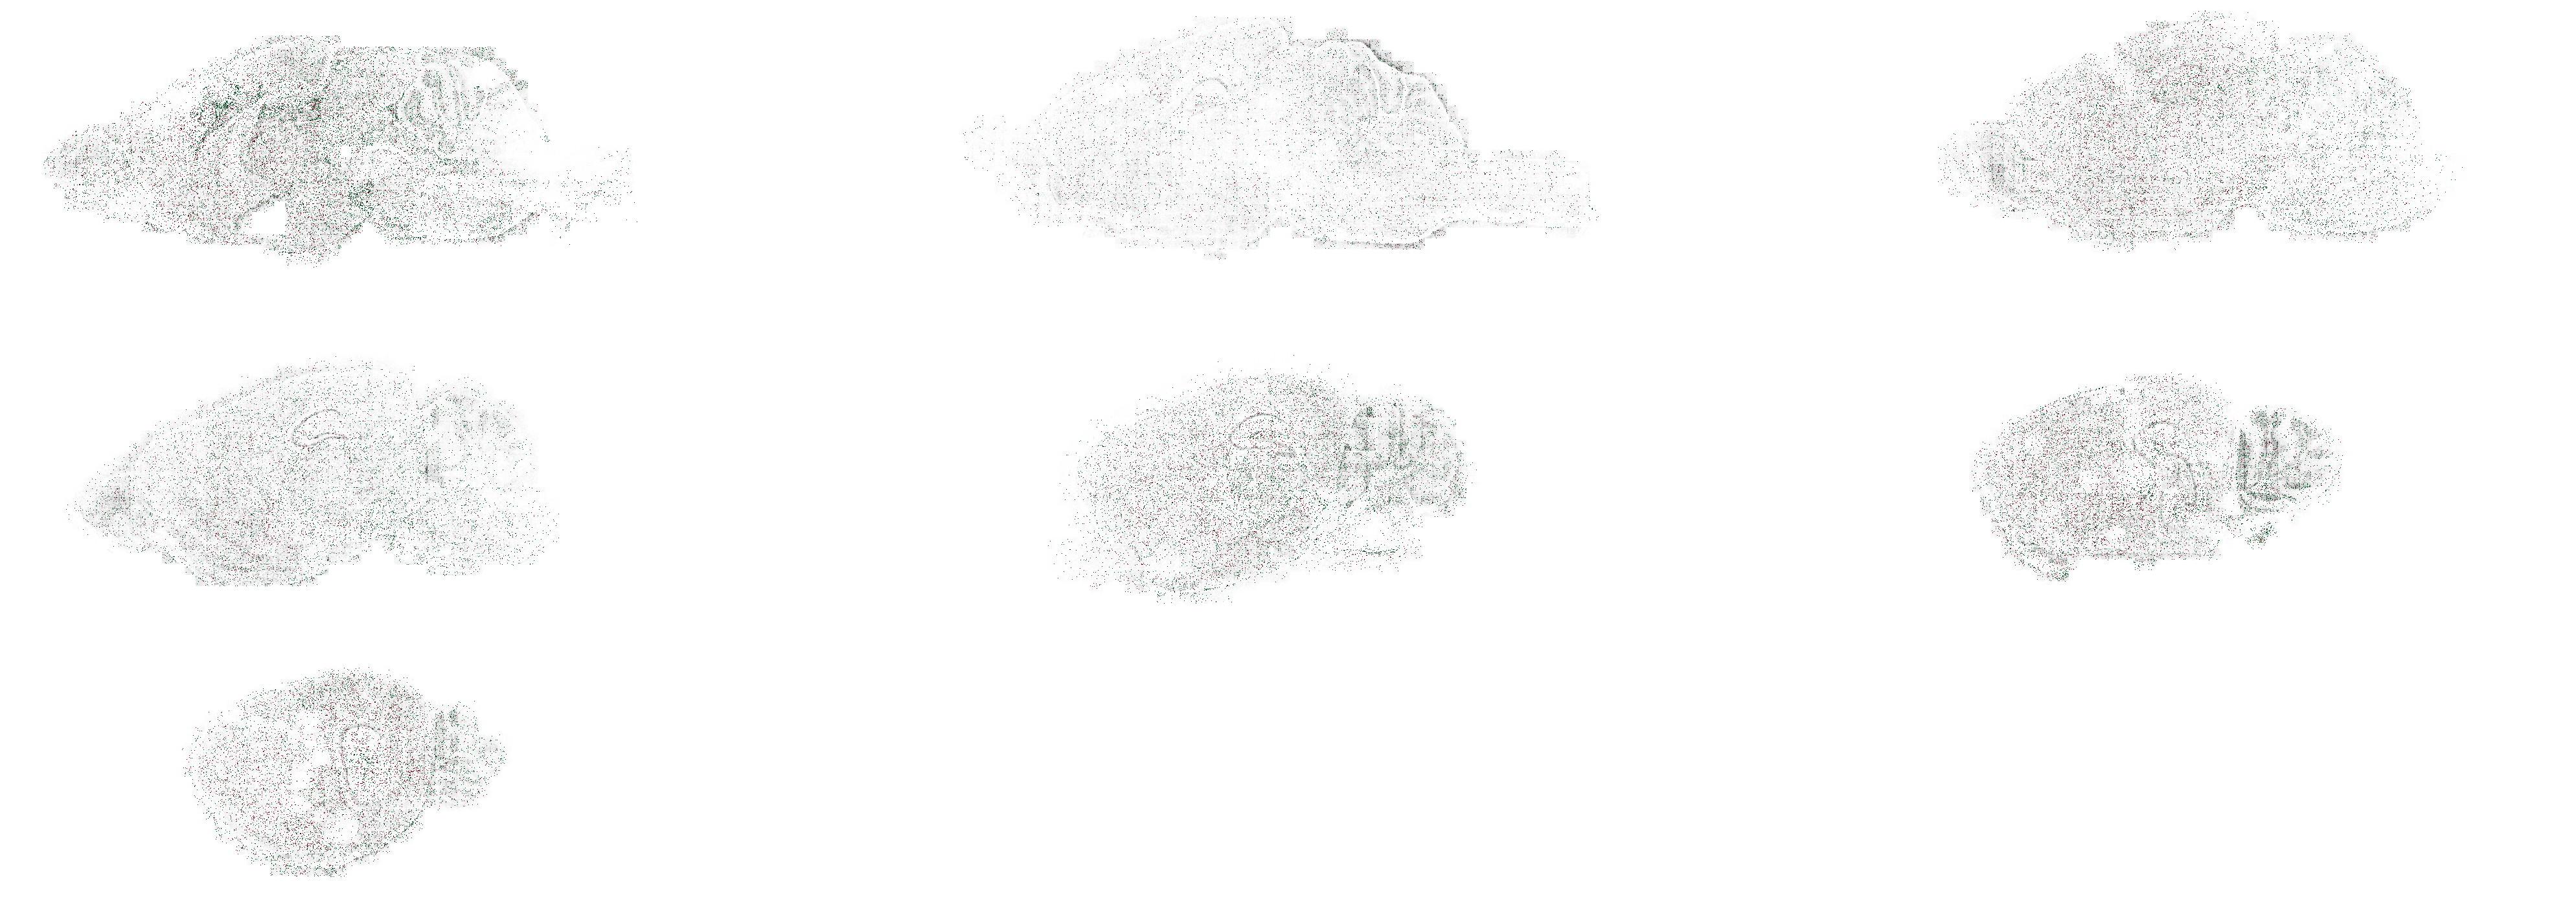

In [7]:
j = 4
plt.figure(figsize=(30,10))

for j in range(7):
    plt.subplot(3, 3, j + 1)
    gene = "Hexb"
    plt.imshow(voxel_data[j, :, :, :].sum(axis=2), cmap=plt.cm.Greys, interpolation="none")
    x = voxel_data[j, :, :, np.where(spatial_genes == gene)[0]][0]
    vmax = np.percentile(voxel_data[:, :, :, np.where(spatial_genes == gene)[0]], 99.5)
    plt.imshow(x, vmax=vmax, cmap=alphareds, interpolation="none")

    gene = "Aqp4"
    x = voxel_data[j, :, :, np.where(spatial_genes == gene)[0]][0]
    vmax = np.percentile(voxel_data[:, :, :, np.where(spatial_genes == gene)[0]], 99.5)
    plt.imshow(x, vmax=vmax, cmap=alphagreens, interpolation="none")
    plt.axis("off")
plt.tight_layout()
None

In [ ]:
# Fit a Bone Fight model (takes ~30 mins for 100 epochs)
# sc_data is (n_cells, n_genes)
# voxel_data is (n_sections, n_y, n_x, n_genes)
a = bf.View(sc_data, n_cells)
b = bf.View(voxel_data, voxel_data.sum(axis=3))
model = bf.BoneFight(a, b)
model.fit(100)
plt.plot(model.losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
None

 79%|███████▉  | 79/100 [1:38:11<32:56, 94.13s/it, loss=-0.57918453]  

In [9]:
# Transform cluster labels
labels = np.eye(265)
# Result will be (n_sections, n_y, n_x, n_clusters)
y = model.transform(labels)

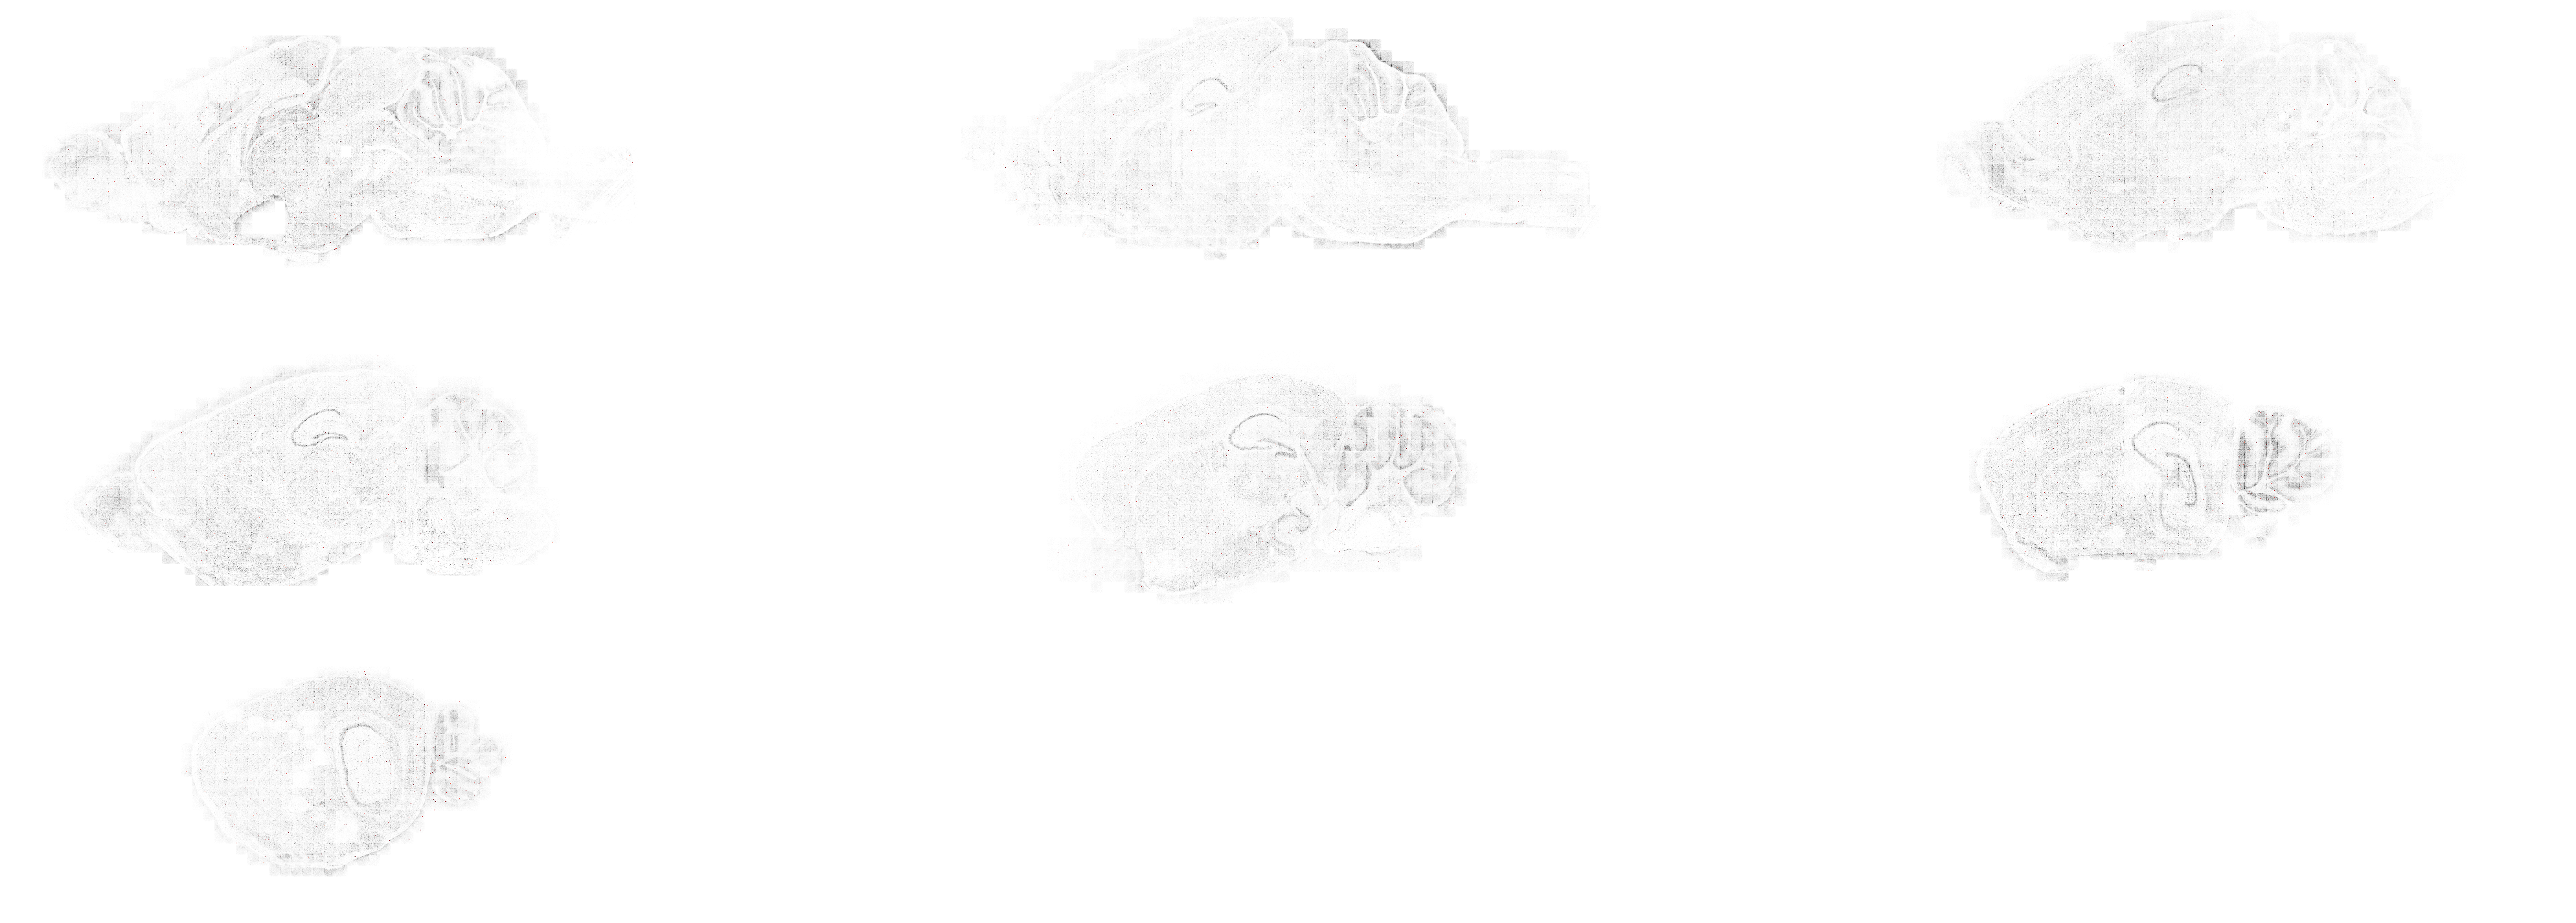

In [29]:
cluster = "HYPEP5"
plt.figure(figsize=(30,10))
with loompy.connect(fagg) as ds:
    i = np.where(ds.ca.ClusterName == cluster)[0]
vmax = np.percentile(y[:, :, :, i][0], 99.99)
for j in range(7):
    plt.subplot(3, 3, j + 1)
    plt.imshow(voxel_data[j, :, :, :].sum(axis=2), cmap=plt.cm.Greys, interpolation="none")
    plt.imshow(y[j, :, :, i][0], vmax=vmax, interpolation="none", cmap=alphareds)
    plt.axis("off")
plt.tight_layout()
None